Performance testing with the generation of graphics to show diferences

In [19]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
from gui.car import Car,generateRandomColor
import graph.graph_parser as gp
from graph.node import Node
from algorithms.bfs import BFS
from algorithms.dfs import DFS
from algorithms.a_star import A_STAR
from algorithms.greedy import GREDDY
from statistics import mean
import pandas as pd
import pygame
import os
import random
import time
import sys

Set Static Variables

In [20]:
sys.setrecursionlimit(10**6)
NumberOfCars=3
StatisticsToShow=['TimeCost','Distance','TopSpeed','AvgSpeed','MedSpeed','StdSpeed','VarSpeed','P25Speed','P50Speed','P75Speed']#TimeCost,Distance,TopSpeed,AvgSpeed,MedSpeed,StdSpeed,VarSpeed,P25Speed,P50Speed,P75Speed




StatMethod={
    "Distance":"tlen",
    "TopSpeed":"getTopSpeed",
    "AvgSpeed":"getAverageSpeed",
    "MedSpeed":"getMedian",
    "StdSpeed":"getStd",
    "VarSpeed":"getVar",
    "P25Speed":"get25Percentil",
    "P50Speed":"get50Percentil",
    "P75Speed":"get75Percentil",
}

Find all circuits that exist
circuits will have the format (Name,File path)

In [21]:
circuits=[]

with os.scandir('gui/circuits/') as circuitsFiles:
    for circuit in circuitsFiles:
        name=circuit.name
        trackName=name.split('.')[0]
        circuits.append((trackName,f'gui/circuits/{name}'))


Get all the algoriths that will be used
algorithms will have the format (Name,class object)

In [22]:
algorithms=[
    ("Depth First Search",DFS()),
    ("Breath First Search",BFS()),
    ("A*",A_STAR()),
    ("Greedy",GREDDY())
    ]

Helper Functions to make the simulation and creating the graph from the sircuit file

In [23]:
def getMatrix(inputImage):
        """
           creates surfaces for the track components and defines max timeline position
        """
        image =  pygame.image.load(inputImage)
        resized_image=pygame.transform.scale(image,(100,50))
        greens=pygame.mask.from_threshold(resized_image,(0,255,0),threshold=(30, 50, 30, 255))
        reds=pygame.mask.from_threshold(resized_image,(255,0,0),threshold=(50, 30, 30, 255))
        blacks=pygame.mask.from_threshold(resized_image,(0,0,0),threshold=(100, 100, 100, 255))
    
        matrix=[]
        for r in range(50):
            f=''
            for c in range(100):
                if greens.get_at((c,r)):
                    f+='P'
                elif reds.get_at((c,r)):
                    f+='F'
                elif blacks.get_at((c,r)):
                    f+='-'
                else:
                    f+='X'
            matrix.append(f)
        return matrix



def getGraphFromImage(inputImage):
    matrix = getMatrix(inputImage)
    graph=gp.circuit_from_matrix(matrix)
    return graph

def simulate(algorithm,graph):
    """
       Uses the algorithm in the track to simulate the car
    """
    cars=[]
    for i in range(NumberOfCars):
        startingNode=random.choice(graph.starts)
        start=time.time()
        d = algorithm.search(graph, Node(startingNode[0], startingNode[1], 0, 0), graph.finishes)
        if d:
            cost,nodes=d
            end=time.time()
            c=Car(color=generateRandomColor(),tlen=cost)
            c.fromNodes(nodes)
            cars.append((end-start,c))
    return cars

In [24]:
data={}

for circuitN,circuitF in circuits:
    graph=getGraphFromImage(circuitF)
    for algorithmN,algorithmI in algorithms:
        print(circuitN,algorithmN)
        if algorithmN=='Greedy' and circuitN!='drag':
            for statA in StatisticsToShow:
                data[statA][circuitN].append(0)
            continue

        cars=simulate(algorithmI,graph)
        costcar=list(zip(*cars)) # transpose
        cost=costcar[0]
        car = costcar[1]
        
        for statA in StatisticsToShow:
            if statA not in data:
                data[statA]={}
            if circuitN not in data[statA]:
                data[statA][circuitN] = []
            if statA=='TimeCost':
                data[statA][circuitN].append(np.mean(cost))
                continue
            funcs = list(map(lambda x:getattr(x,StatMethod[statA]),car))
            if statA=='Distance':
                data[statA][circuitN].append(np.mean(funcs))
                continue
            values = list(map(lambda x: x(),funcs))
            data[statA][circuitN].append(np.mean(values))

drag Depth First Search
drag Breath First Search
drag A*
drag Greedy
spielberg Depth First Search
spielberg Breath First Search
spielberg A*
spielberg Greedy
overkill Depth First Search
overkill Breath First Search
overkill A*
overkill Greedy
melbourne Depth First Search
melbourne Breath First Search
melbourne A*
melbourne Greedy
montreal Depth First Search
montreal Breath First Search
montreal A*
montreal Greedy
austin Depth First Search
austin Breath First Search
austin A*
austin Greedy
barcelona Depth First Search
barcelona Breath First Search
barcelona A*
barcelona Greedy
imola Depth First Search
imola Breath First Search
imola A*
imola Greedy
bahrain Depth First Search
bahrain Breath First Search
bahrain A*
bahrain Greedy
badImage Depth First Search
badImage Breath First Search
badImage A*
badImage Greedy
silverstone Depth First Search
silverstone Breath First Search
silverstone A*
silverstone Greedy
mexico Depth First Search
mexico Breath First Search
mexico A*
mexico Greedy
buda

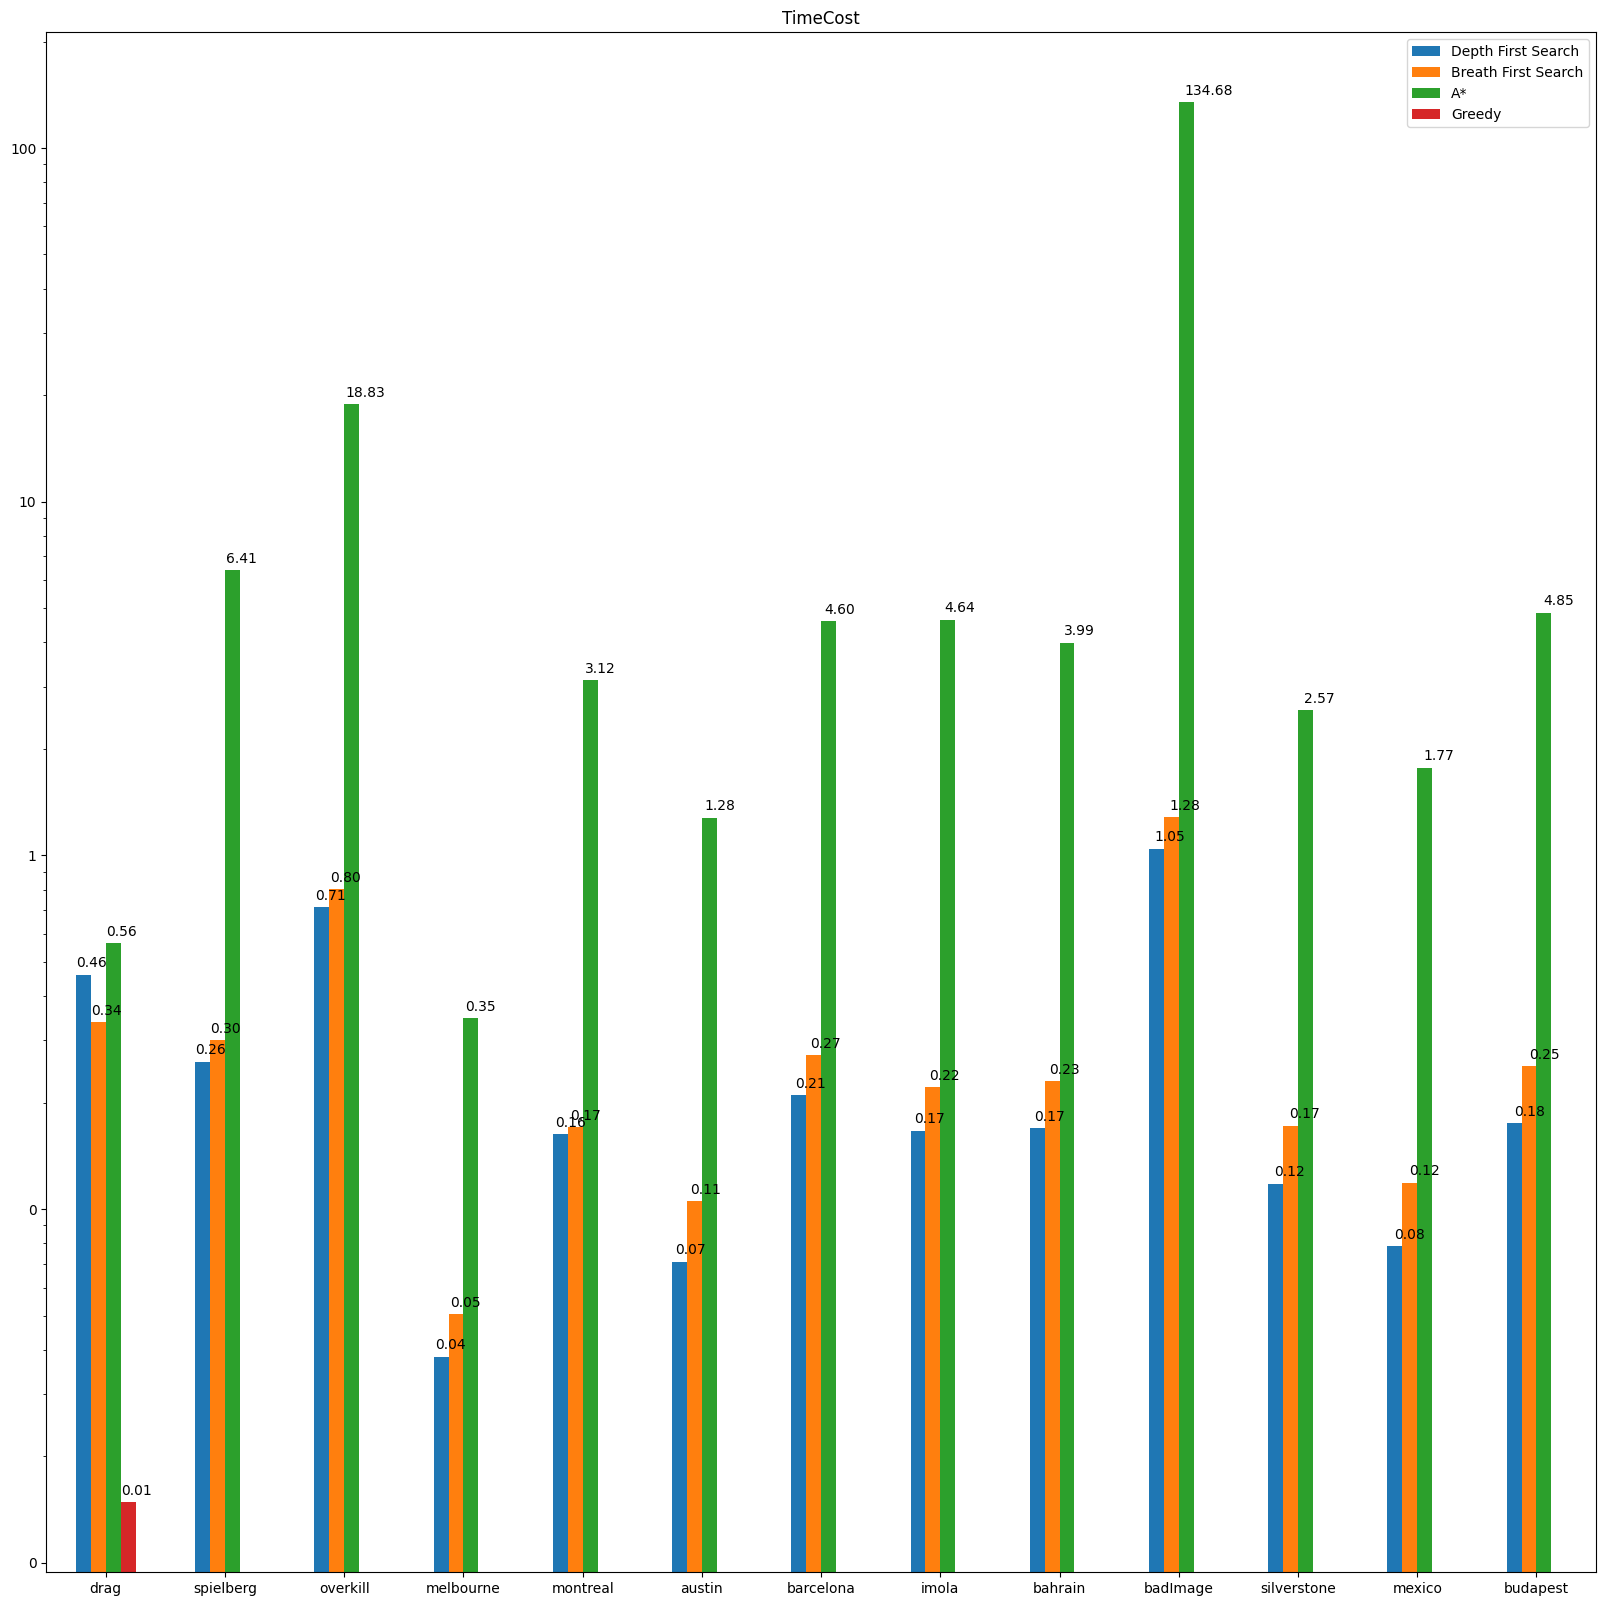

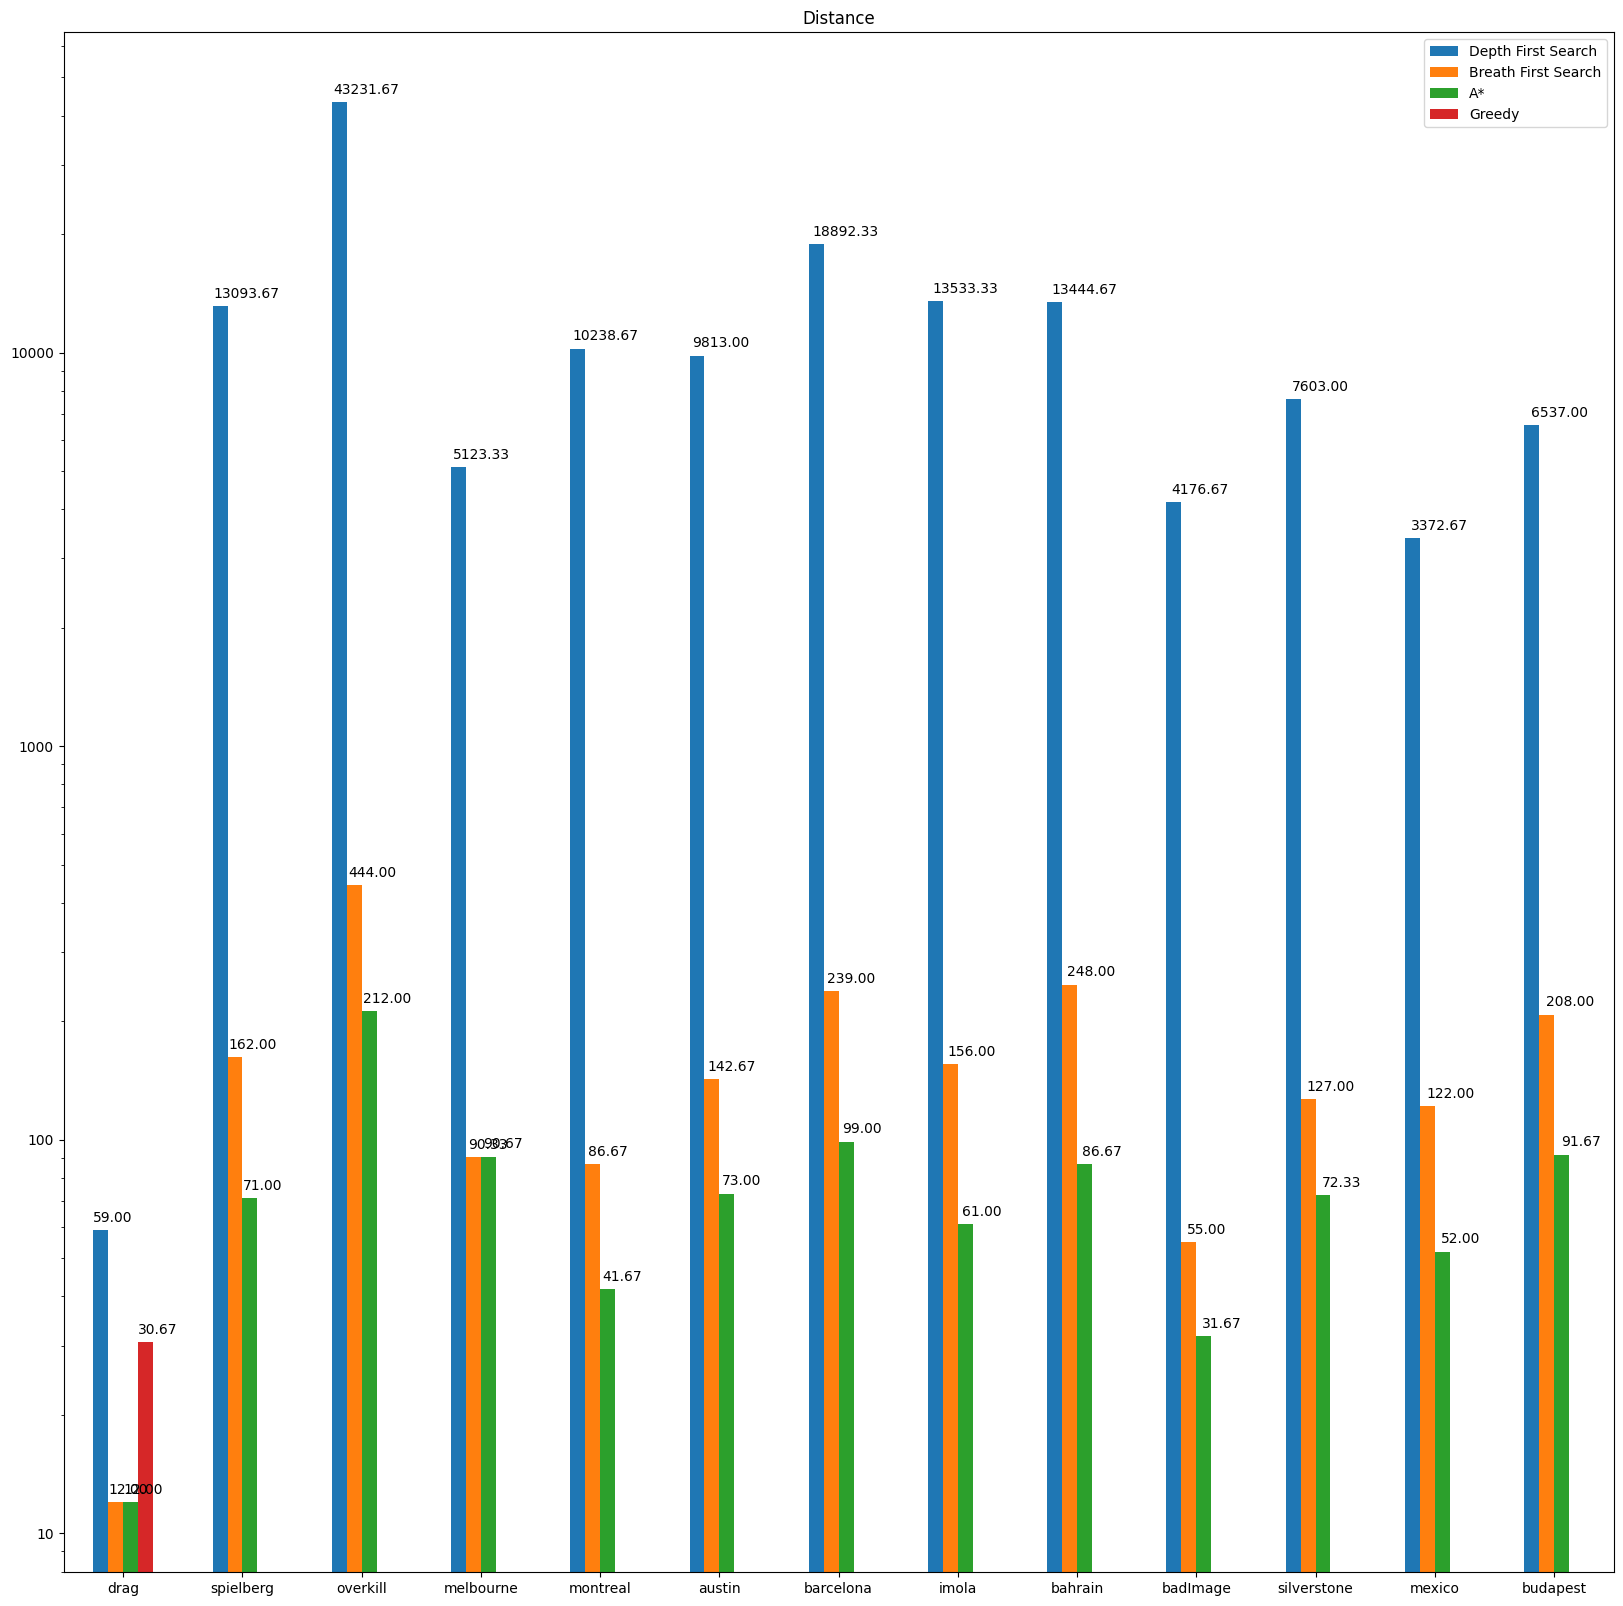

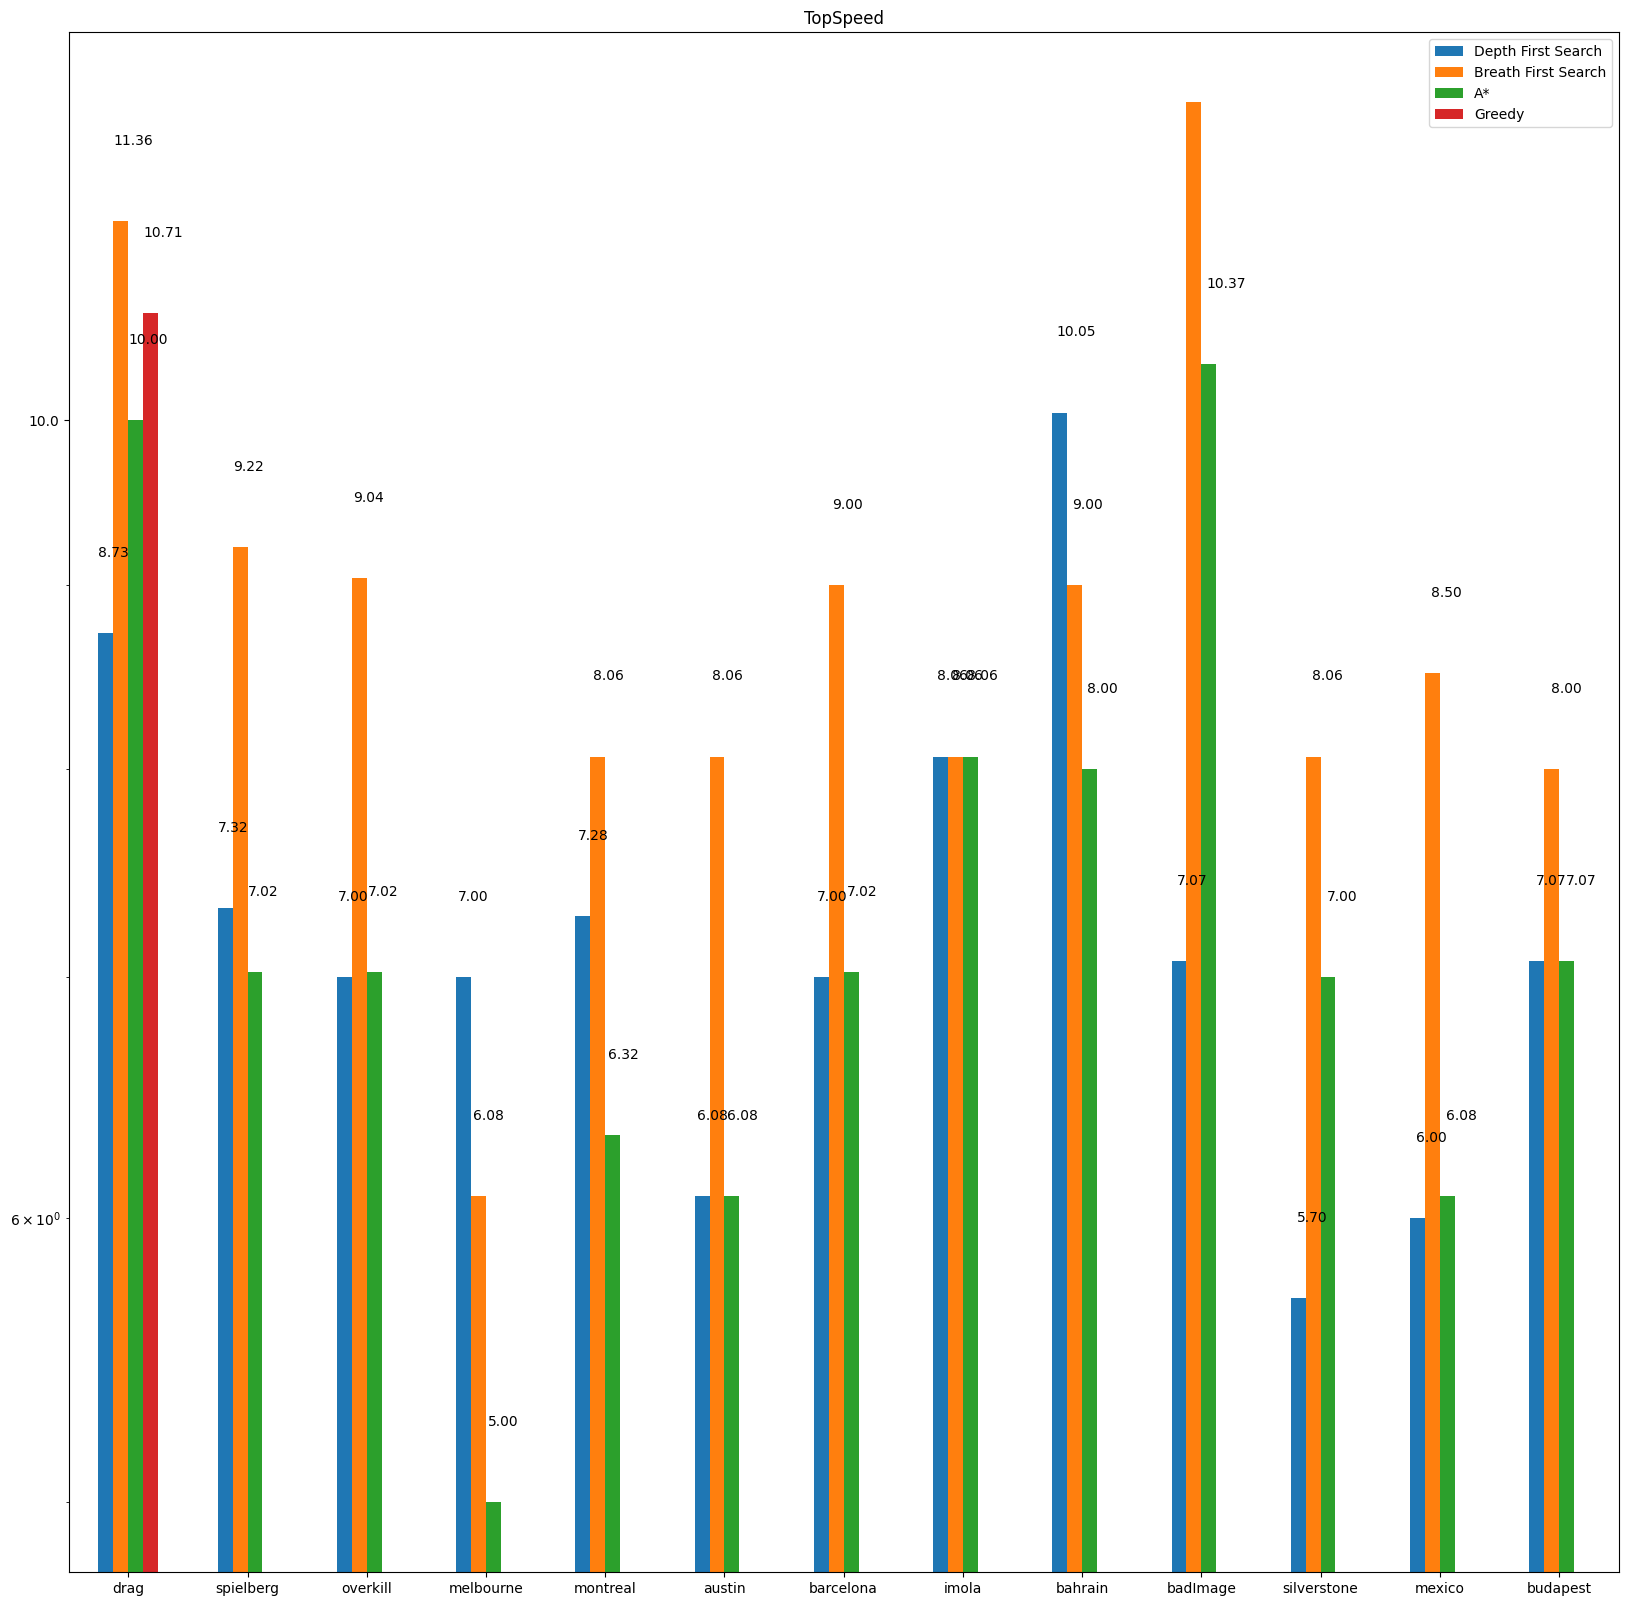

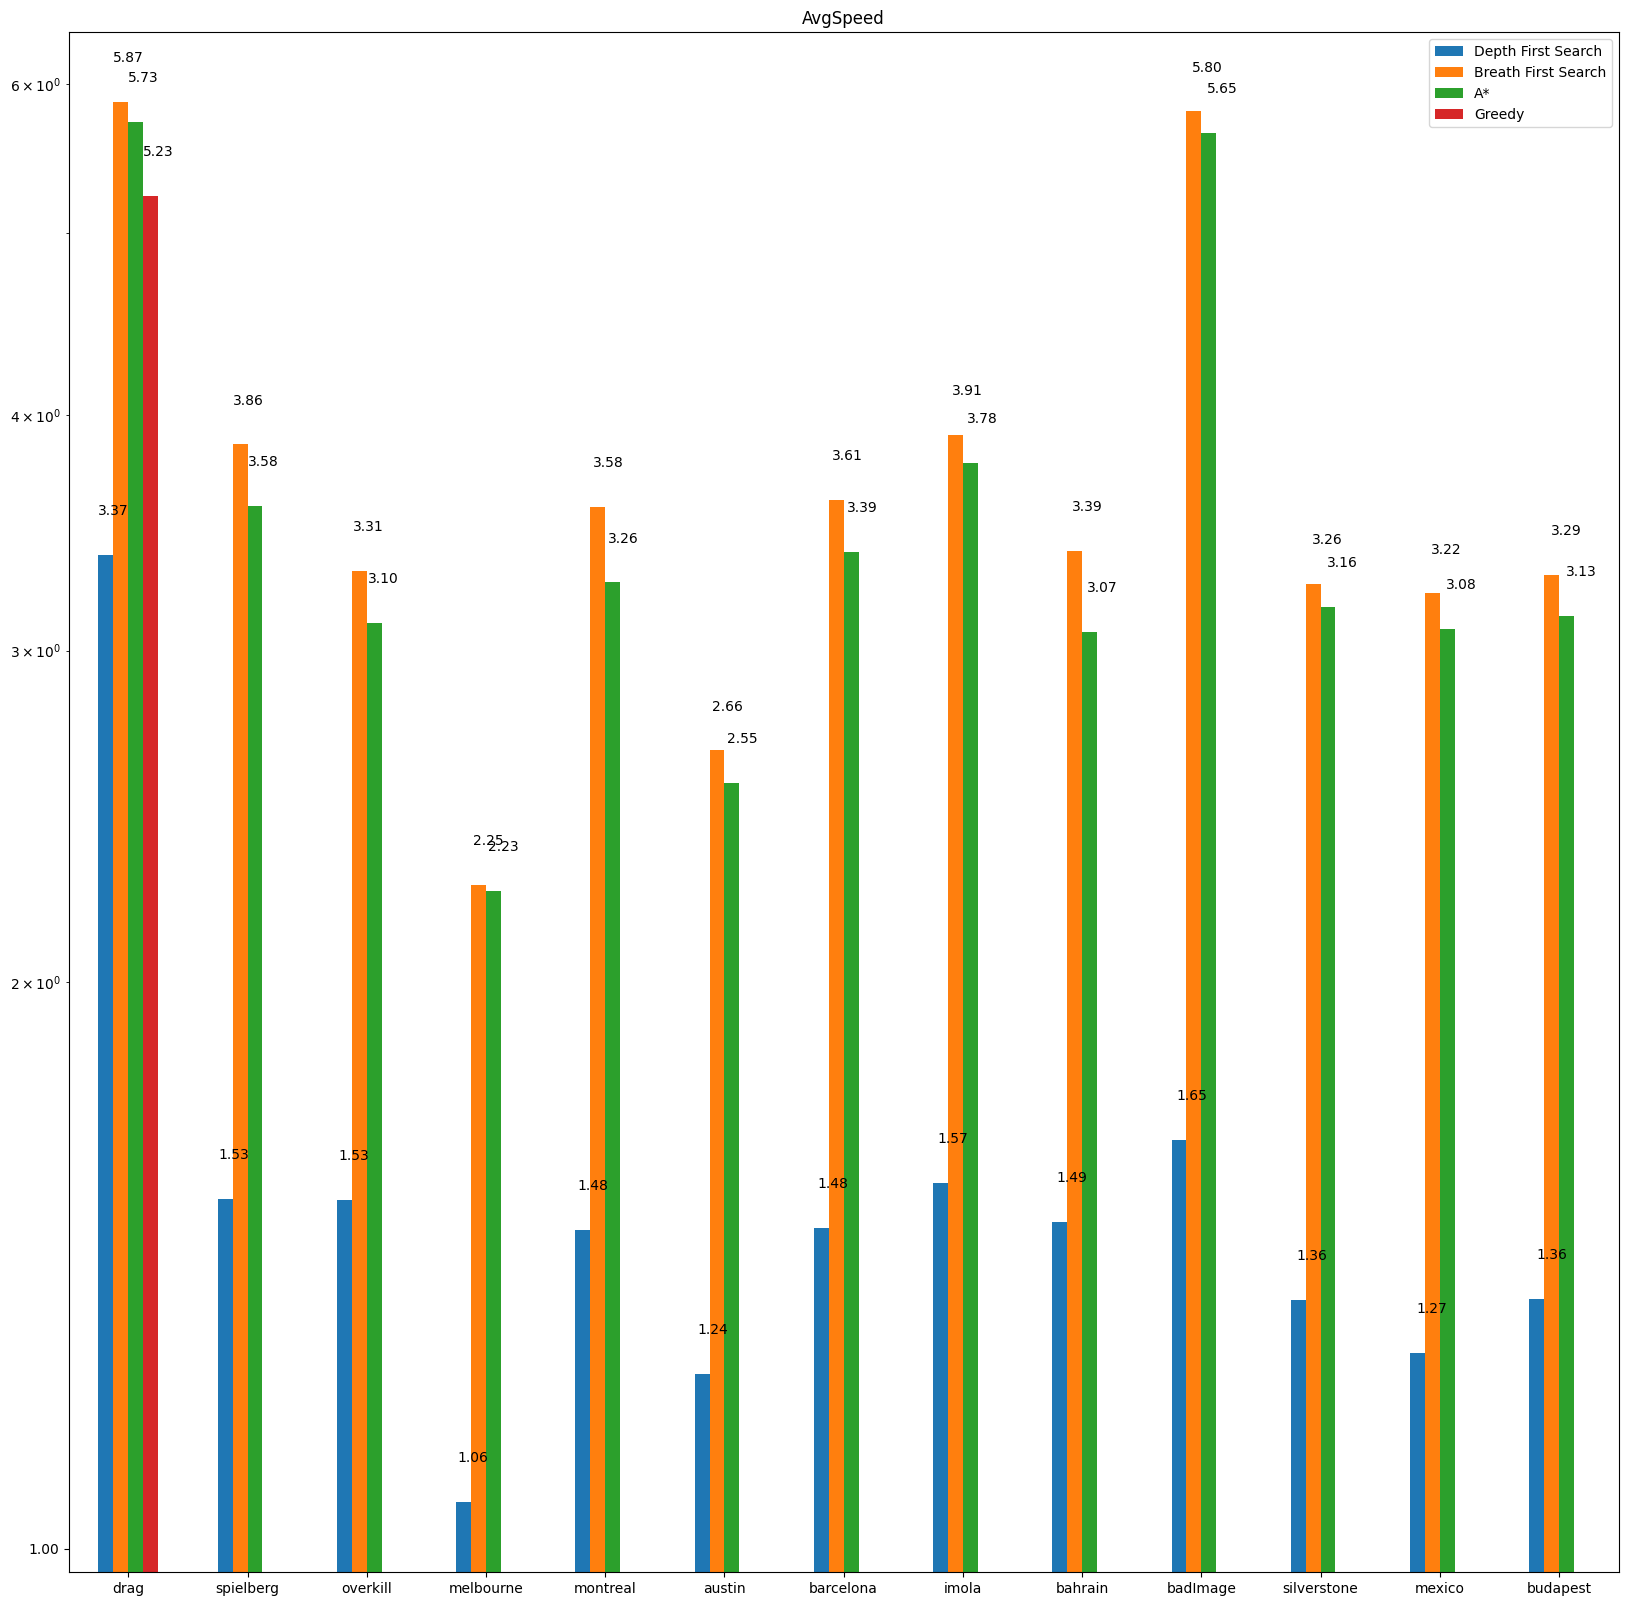

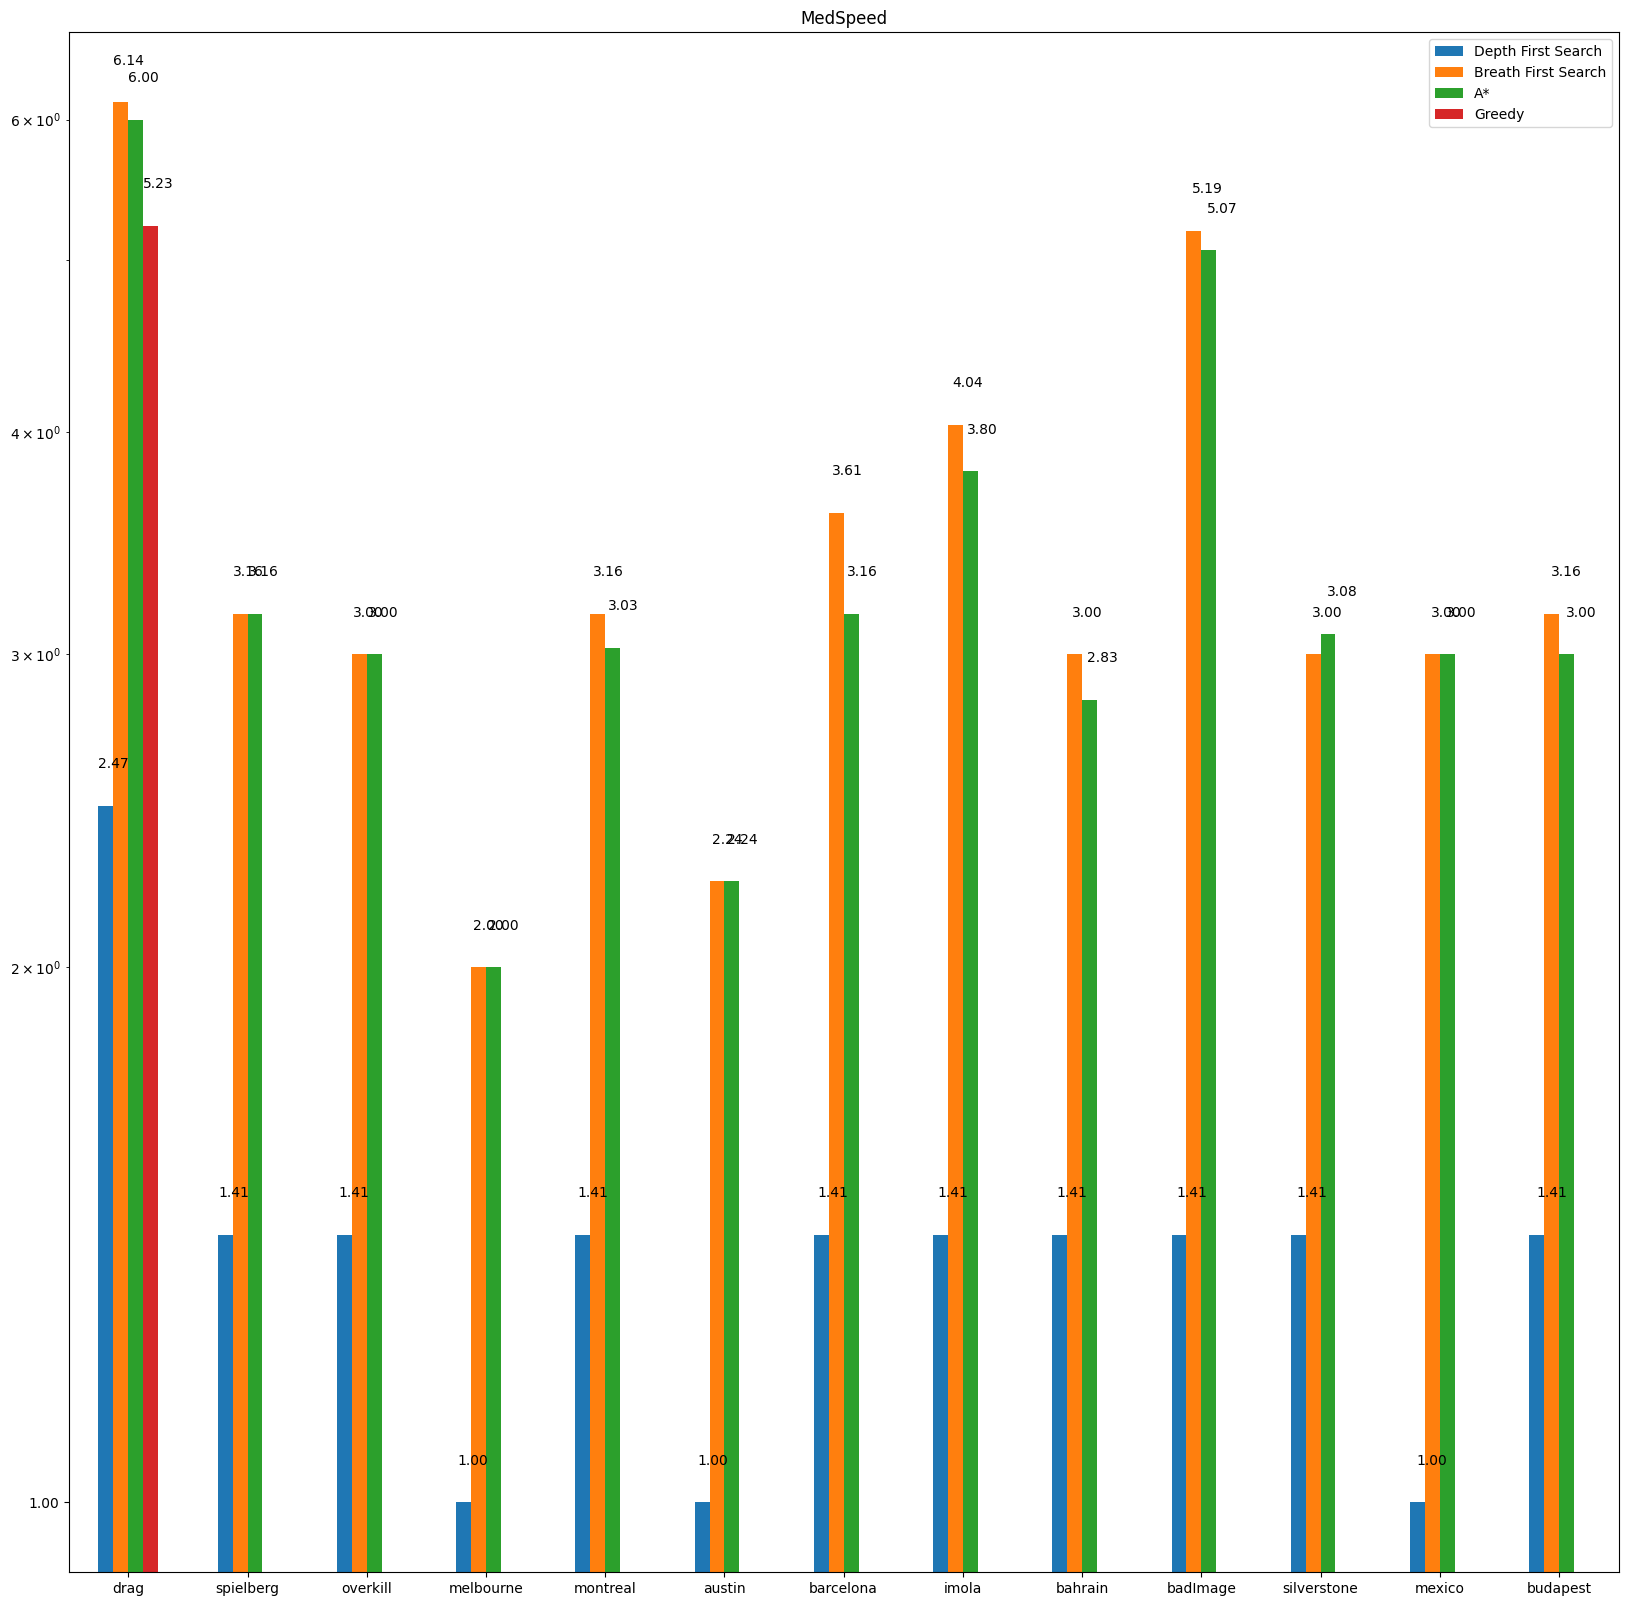

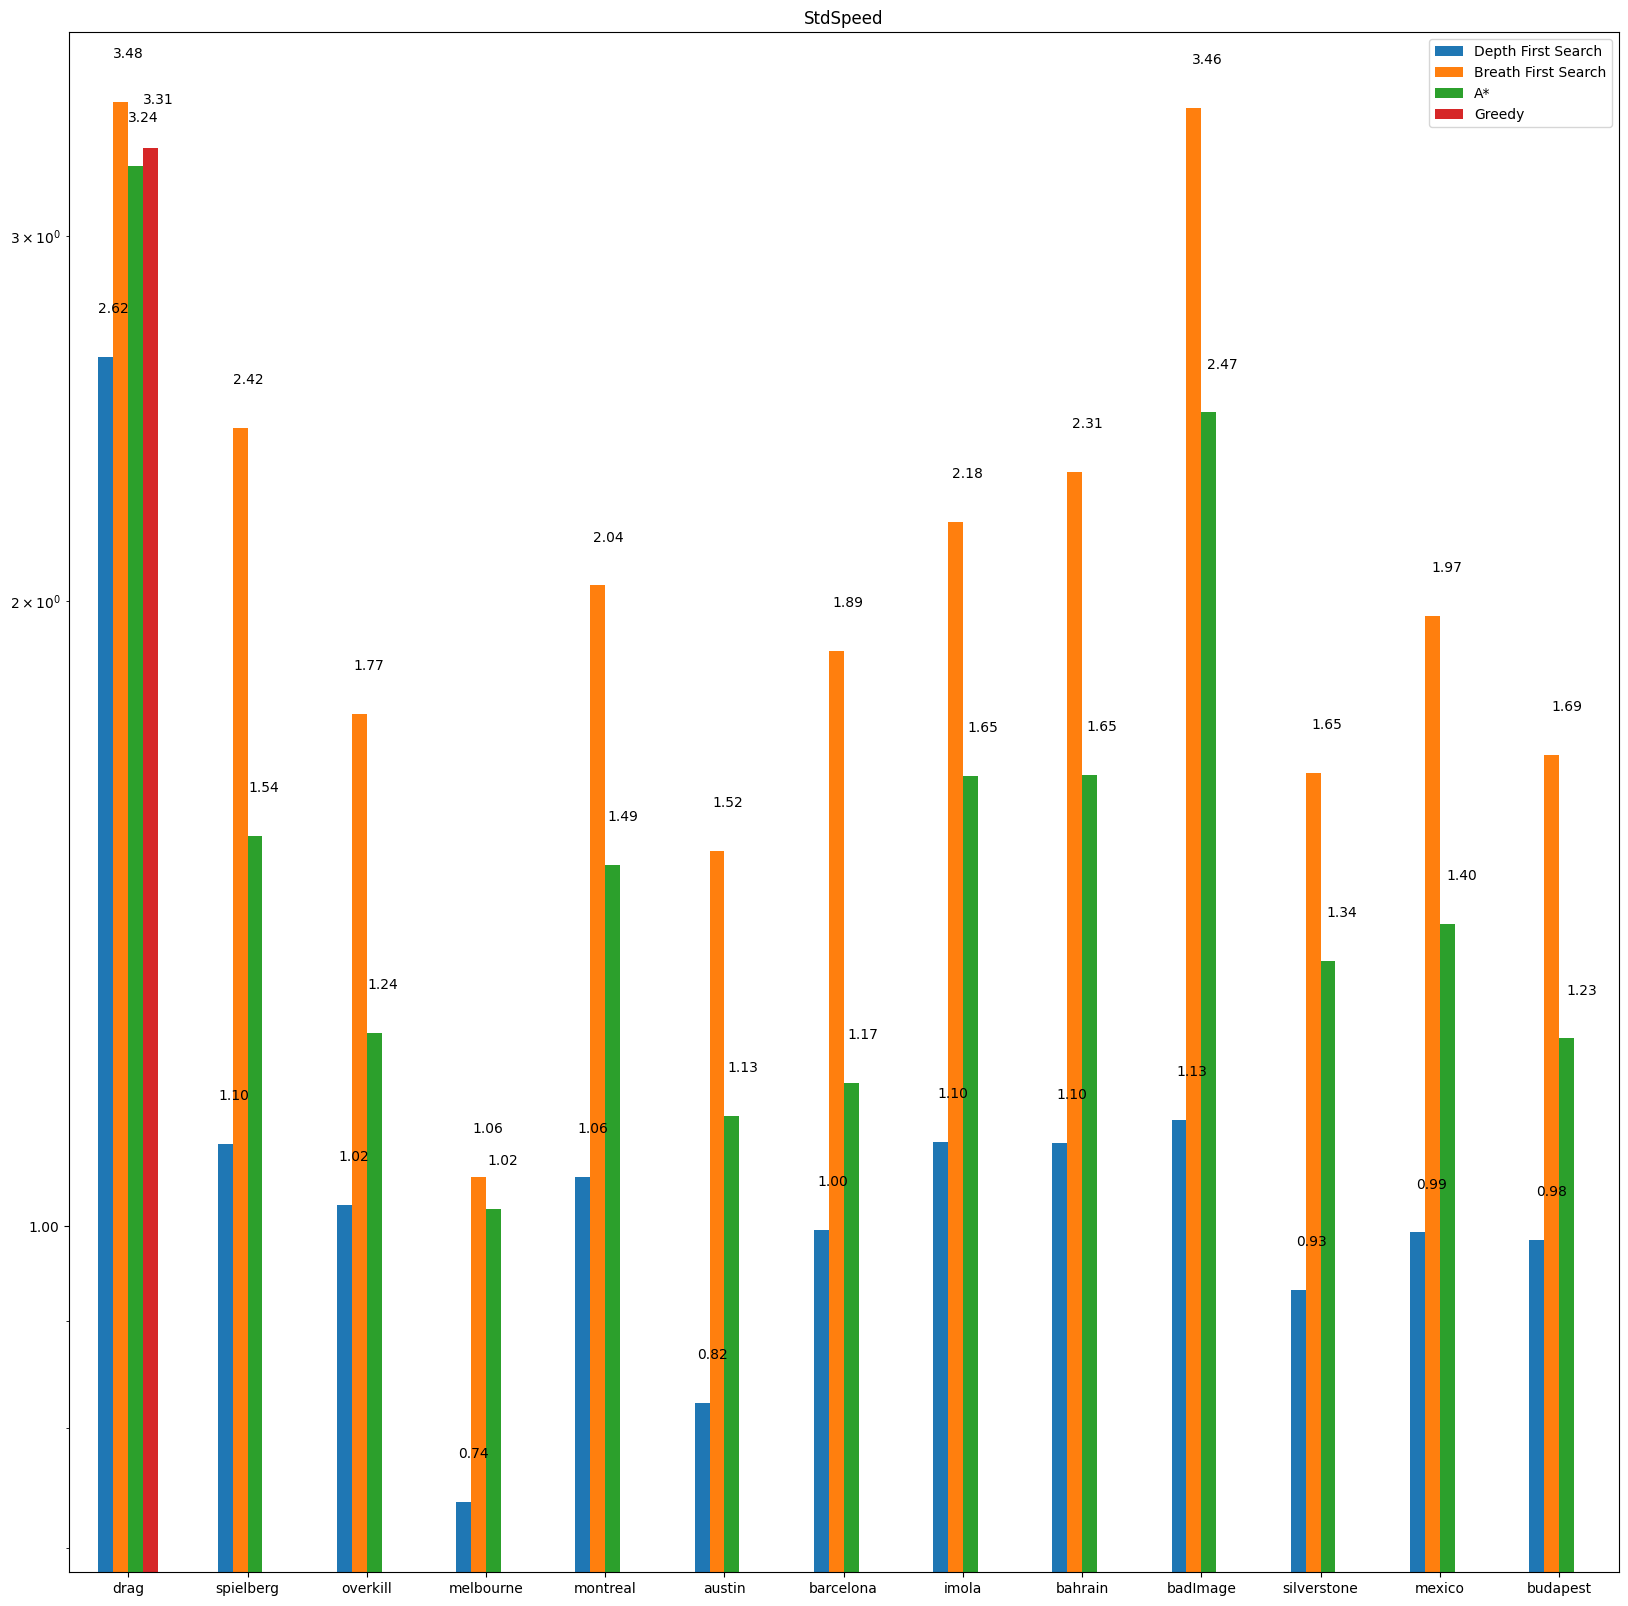

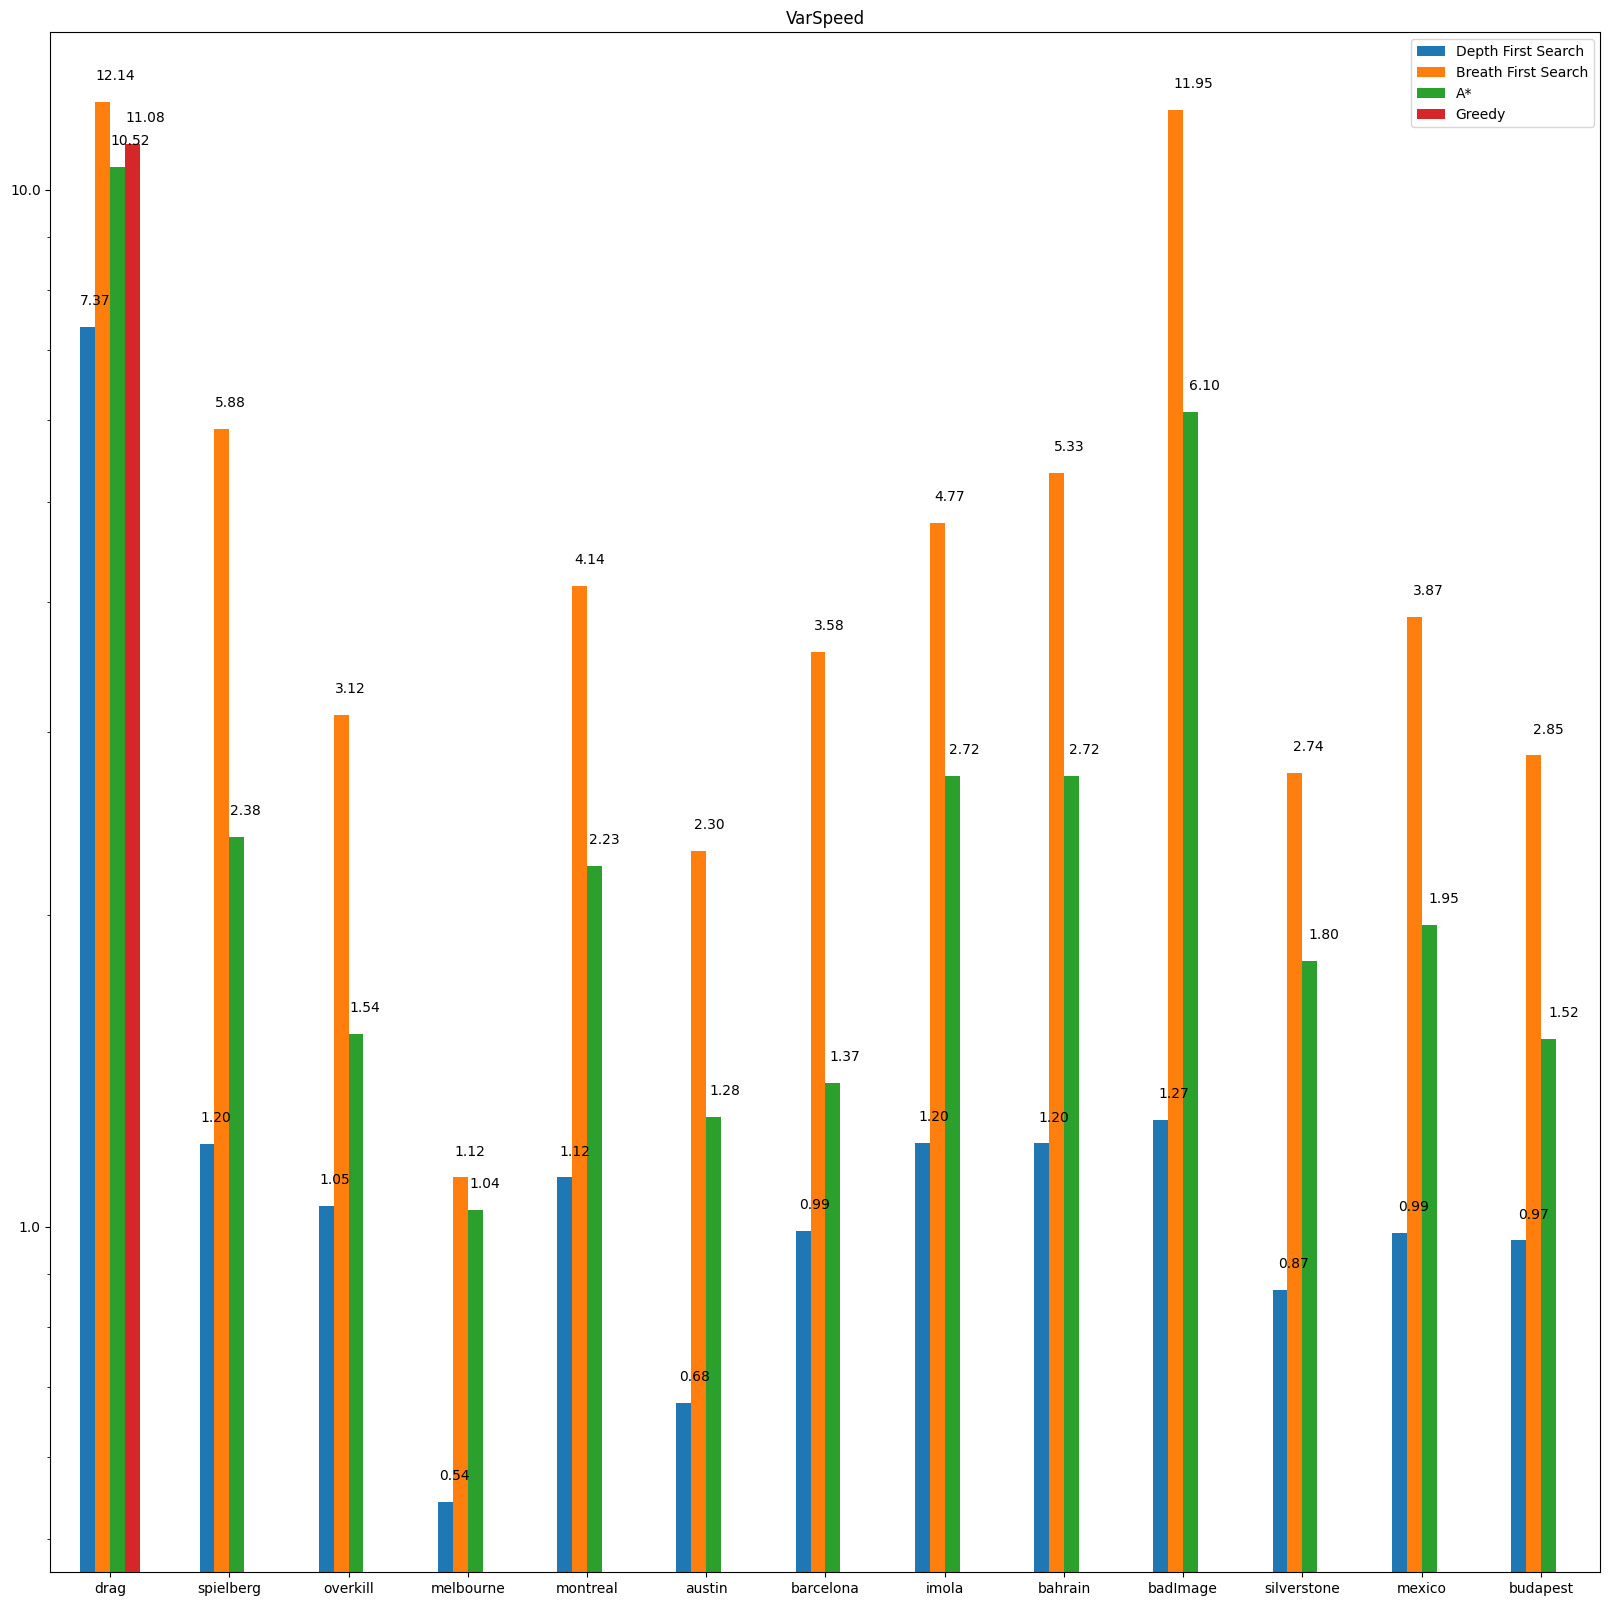

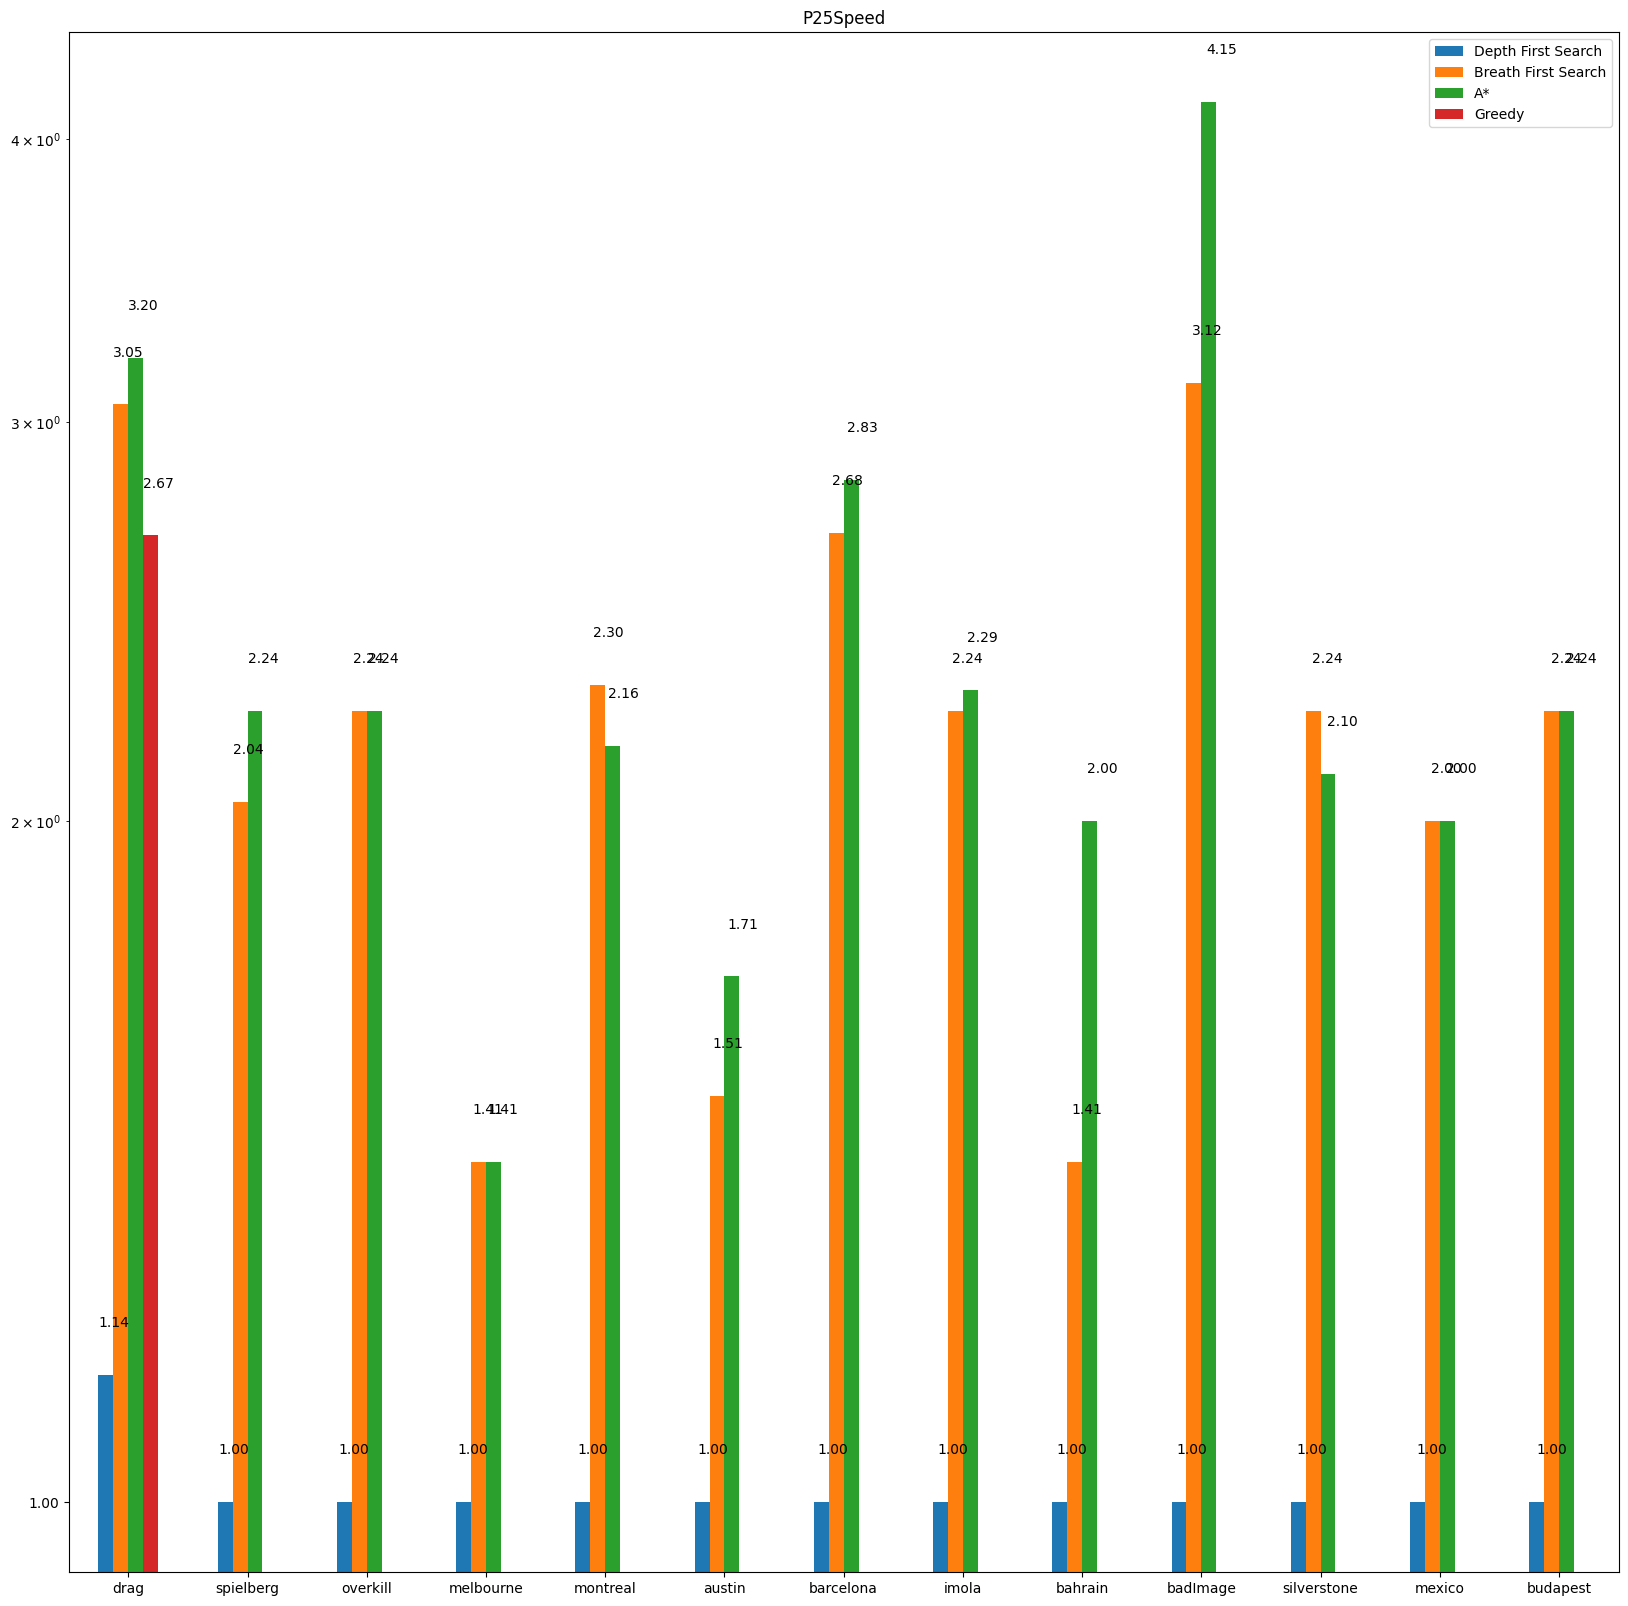

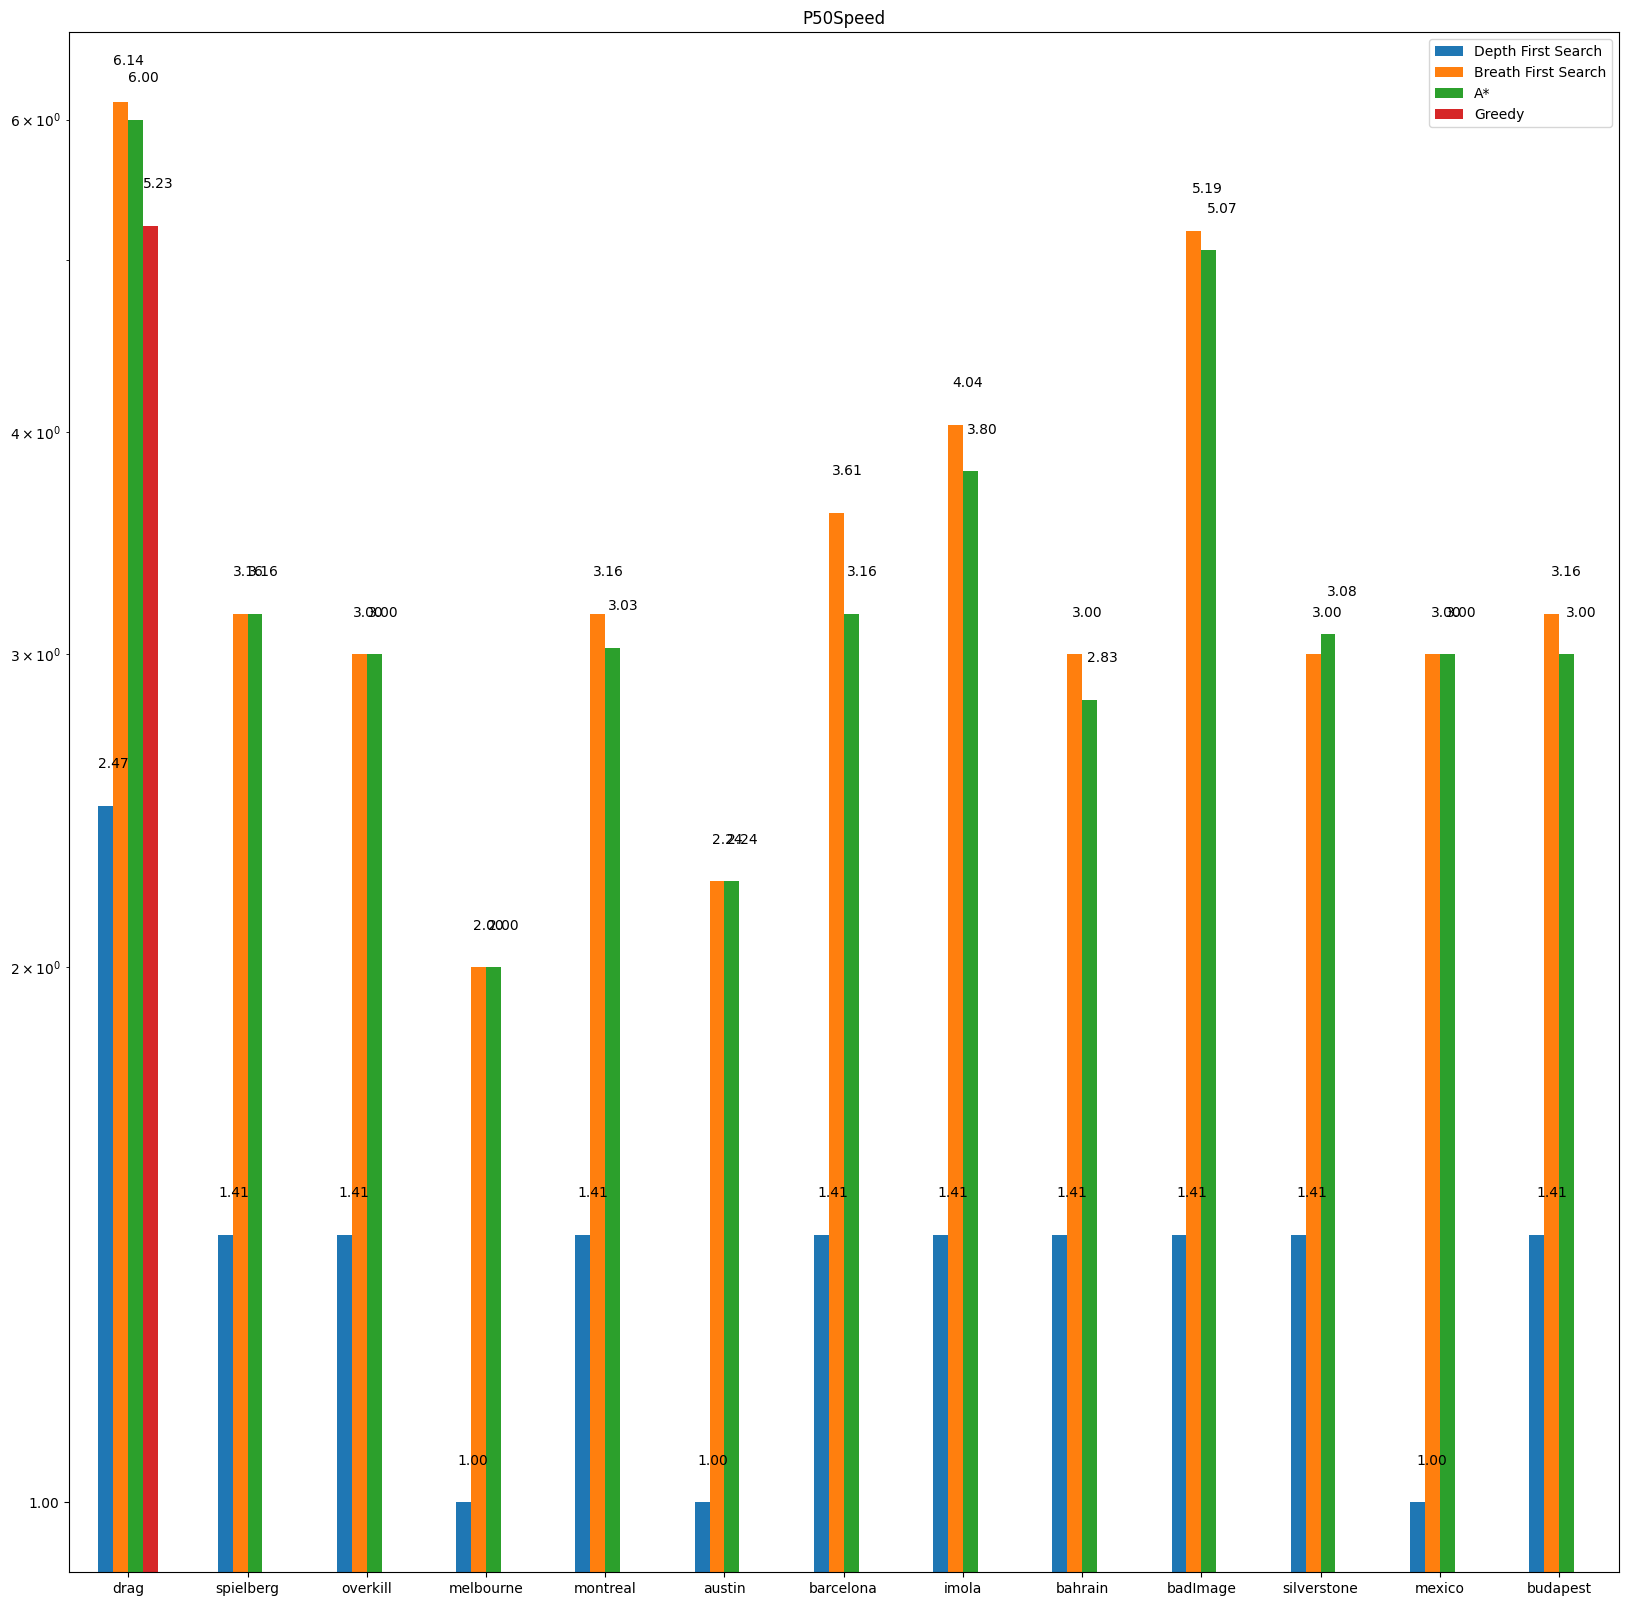

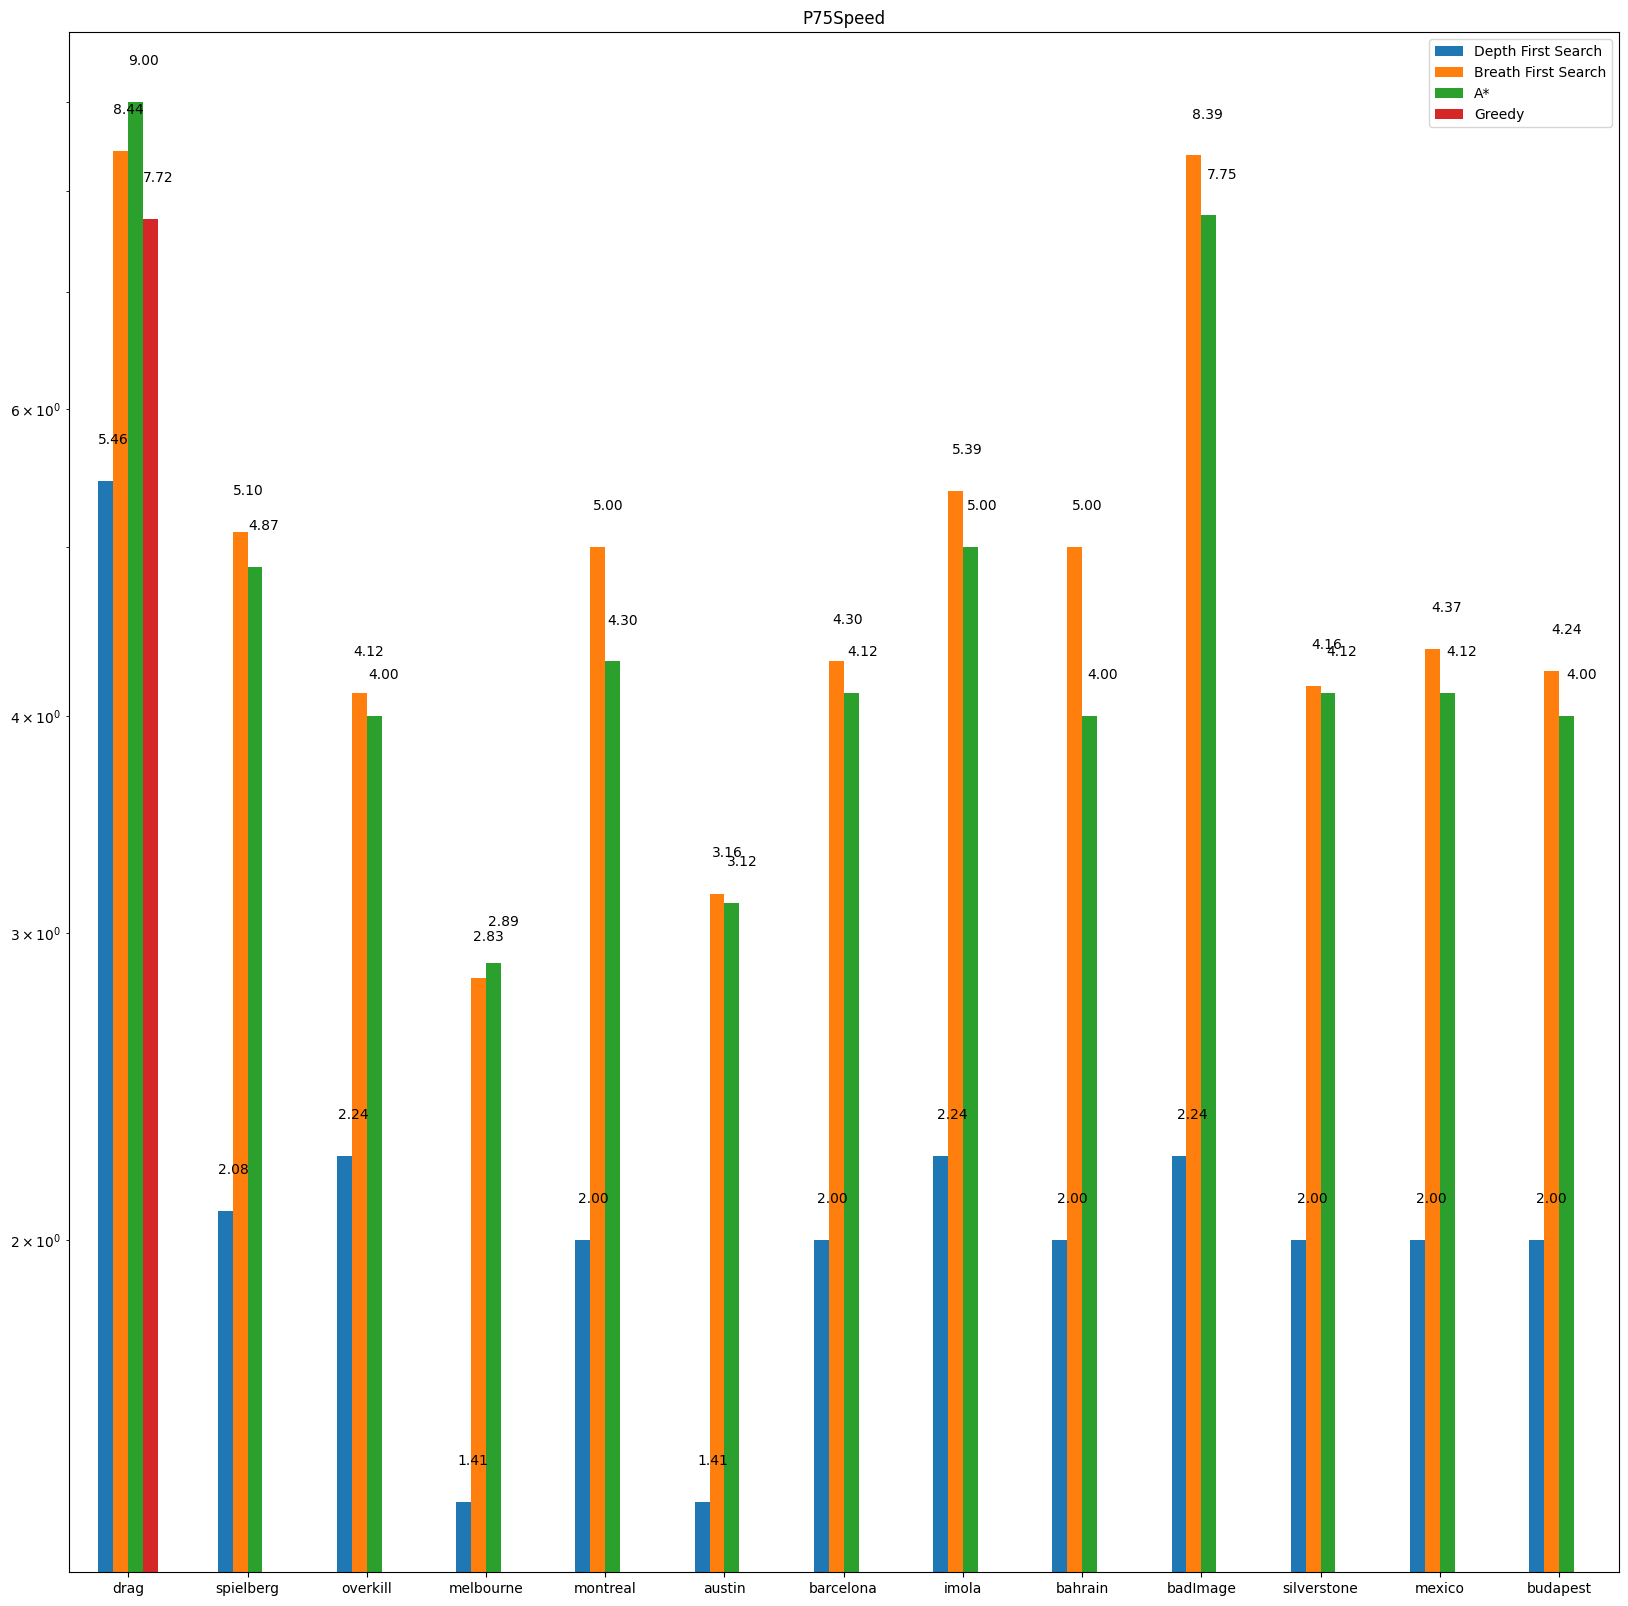

In [25]:



dataframes={}
algorithmsNames=list(zip(*algorithms))[0]
for stat,statData in data.items():
    dataframes[stat]=pd.DataFrame.from_dict(statData,orient='index',columns=algorithmsNames)
for stat,df in dataframes.items():
    ax = df.plot(kind="bar", rot=0,title=stat,figsize=(20,20))
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.2f}", (p.get_x() * 1.005, p.get_height() * 1.05))
